## Ahmad Hojatimalekshah

### Collaborate: Arash Modaresi, Amir Kazemzadeh, Ali Nazari

# CS534 Homework 4

### Loading the library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, cm
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate,KFold
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN, KMeans
from sklearn import model_selection, metrics, datasets, svm
import warnings
warnings.filterwarnings('ignore')

# Question 1 (15 pts)

Implement the ADABoost algorithm by using the scikit implementation of the logistic regression. Evaluate the result on a real dataset between a single logistic regression and AdaBoost (use K-Fold cross validation).

This links can be helpful: http://rob.schapire.net/papers/explaining-adaboost.pdf and https://en.wikipedia.org/wiki/AdaBoost


### Load the data

In [2]:
X, y = load_breast_cancer(return_X_y=True)

### Split the data to train and test

In [3]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### AdaBoost function

In [4]:
def AdaBoost(X,y, n_estimator):
    
    #Initial variables
    n = len(y)
    clf_list = [] 
    amount_of_say_list = [] 
    smpl_weight_list = []

    #Initial sample weights
    smpl_weight = np.ones(n) / n
    smpl_weight_list.append(smpl_weight.copy())

    for m in range(n_estimator):   

        #Fit a classifier
        clf = LogisticRegression()
        clf.fit(X, y, sample_weight=smpl_weight)
        y_p = clf.predict(X)

        #Misclassifications
        incorrect = (y_p != y)

        #Total error
        Total_error = np.mean(np.average(incorrect, weights=smpl_weight, axis=0))
        
        #Amount of Say
        amount_of_say =  0.5 * np.log((1 - Total_error) / Total_error)

        #Sample weights
        smpl_weight *= np.exp(amount_of_say * incorrect * ((smpl_weight > 0) | (amount_of_say < 0)))

        #Append the computed values
        clf_list.append(clf)
        amount_of_say_list.append(amount_of_say.copy())
        
    #List of results   
    clf_list = np.asarray(clf_list)
    amount_of_say_list = np.asarray(amount_of_say_list)
    
    return clf_list, amount_of_say_list

### K-fold Cross Validation

In [5]:
# Number of splits
n_splits = 5

# Defining a K-Fold cross validation
skf = KFold(n_splits=n_splits,random_state=1234,shuffle=True )

n_estimator = 5
y_p_list = []
AdB_acc_list = []
lg_acc_list = []

# Train and validation data index
ind = list(skf.split(X, y))

# K-fold cross validation
for j in range(0,n_splits):
    
    y_p_list = []
    
    # Train and validation data for each fold
    X_train = X[ind[j][0]]
    y_train = y[ind[j][0]]
    X_valid = X[ind[j][1]]
    y_valid = y[ind[j][1]]
    
    n = len(X_valid)

    # Standardize the train and validation data
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_valid_std = sc.transform(X_valid)

    # Fitting the AdaBoost classifiers
    clf_list, amount_of_say_list = AdaBoost(X_train_std, y_train,n_estimator)
    
    # Fitting logistic regression classifier
    lg = LogisticRegression(random_state=1234).fit(X_train_std, y_train)
    
    # AdaBoost Predictions for validation per each classifier
    for i in range(n_estimator):
        y_p = clf_list[i].predict(X_valid_std)
        y_p_list.append(y_p.copy())
    
    # make a list of logistic regression validation accuracy per each fold
    lg_acc_list.append(lg.score(X_valid_std, y_valid))
        
    # AdaBoost validation accuracy
    y_p_list = np.asarray(y_p_list)
    preds = (np.array([np.sign((y_p_list[:,point] * amount_of_say_list).sum()) for point in range(n)]))
    acc = (preds == y_valid).sum() / n
    AdB_acc_list.append(acc.copy())
    
print('AdaBoost Validation Accuracy = ', np.mean(AdB_acc_list))
print('Logistic regression Validation Accuracy = ', np.mean(lg_acc_list))


AdaBoost Validation Accuracy =  0.954778481012658
Logistic regression Validation Accuracy =  0.9823417721518988


### Adaboost Test Accuracy

#### Lets Standardize the test and train

In [6]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X)
X_test_std = sc.transform(X_test)

In [7]:
# Initial values
y_p_list = []
n = len(X_test_std)

# Fitting the classifiers
clf_list, amount_of_say_list = AdaBoost(X_train_std, y,n_estimator)

# Test prediction
for i in range(n_estimator):
    y_p = clf_list[i].predict(X_test_std)
    y_p_list.append(y_p.copy())
        
# Test Accuracy
y_p_list = np.asarray(y_p_list)
preds = (np.array([np.sign((y_p_list[:,point] * amount_of_say_list).sum()) for point in range(n)]))
acc = (preds == y_test).sum() / n
    
print('AdaBoost Test Accuracy = ', acc)

AdaBoost Test Accuracy =  0.9298245614035088


### Logistic Regression Test Accuracy

In [8]:
# Lets fit model by train
lg_model = LogisticRegression(random_state=1234).fit(X_train_std, y)

# Test Prediction
y_pred = lg_model.predict(X_test_std)

# Test Accuracy
print("Logistic Regression Tese Accuracy :",metrics.accuracy_score(y_test, y_pred))

Logistic Regression Tese Accuracy : 0.9707602339181286


I expected to see test accuracy be greater in Adaboost rather than single logistic regression because AdaBoost gives higher weights to the incorrect lables and tries to predict those in addition to the first logistic regression it fits to the data. However, if we increase the number of estimator for Adaboost it may overfit and give lower accuracy for unknown lables (tests) rather than single logistic regression.

## Question 2 (10 pts)
Use DBscan (try with different parameters) and K-means (K=3) on IRIS Dataset and discuss/compare the results with the iris ground truth.
Please provide an explanation of why K-fold cross validation is not required for the comparison among these different algorithms.

In [9]:
def dbscan(X,eps,min_samples,labels_true):
    
    # Compute DBSCAN
    db = DBSCAN(eps = eps, metric = 'euclidean', min_samples = min_samples).fit(X)
    labels = db.labels_
    
    # Homogeneity
    hmgnty = metrics.homogeneity_score(labels_true, labels)
    print('Homogeneity = ', hmgnty)
    
    # Completeness
    cmpltnss = metrics.completeness_score(labels_true, labels)
    print('Completeness = ', cmpltnss)
    
    # V-measure
    vmeasr = metrics.v_measure_score(labels_true, labels)
    print('V_measure = ', vmeasr)
    
    # Adjusted Rand Index
    adjrnd = metrics.adjusted_rand_score(labels_true, labels)
    print('Adjusted rand = ', adjrnd)
    
    # Adjusted Mutual Information
    mutinfo = metrics.adjusted_mutual_info_score(labels_true, labels)
    print('Adjusted Mutual Information',mutinfo)

### Plot Function

In [10]:
def dbscan_plot(X,eps, min_samples):
    
    # DBscan fit
    db = DBSCAN(eps = eps, metric = 'euclidean', min_samples = min_samples).fit(X)
    labels = db.labels_
    
    # mask
    co = np.zeros_like(db.labels_, dtype=bool)
    co[db.core_sample_indices_] = True
    
    # unique lables
    unqlbl = set(labels)
    
    # number of clusters
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Color for each cluster
    colors = [plt.cm.autumn(l) for l in np.linspace(0, 1, len(unqlbl))]
       
    fig = plt.figure(figsize=(15, 10))
    
    # Plot
    for i, j in zip(unqlbl, colors):
        if i == -1:
            # Black used for noise.
            j = [0, 0, 0, 1]

        cl = (labels == i)

        xy = X[cl & co]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(j), markersize=15, markeredgecolor='k')

        xy = X[cl & ~co]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(j), markersize=7, markeredgecolor='k')

    plt.title('Number of clusters: %d' % n_clusters_)
    plt.show()

### Load iris data

In [11]:
iris = datasets.load_iris()
X = iris.data
labels_true = iris.target
X = StandardScaler().fit_transform(X)

### eps = 0.5 & min_samples = 5

In [12]:
dbscan(X,0.5,5,labels_true)

Homogeneity =  0.5005010857048665
Completeness =  0.522846554194579
V_measure =  0.5114298559522713
Adjusted rand =  0.44209866858859237
Adjusted Mutual Information 0.4942363179976064


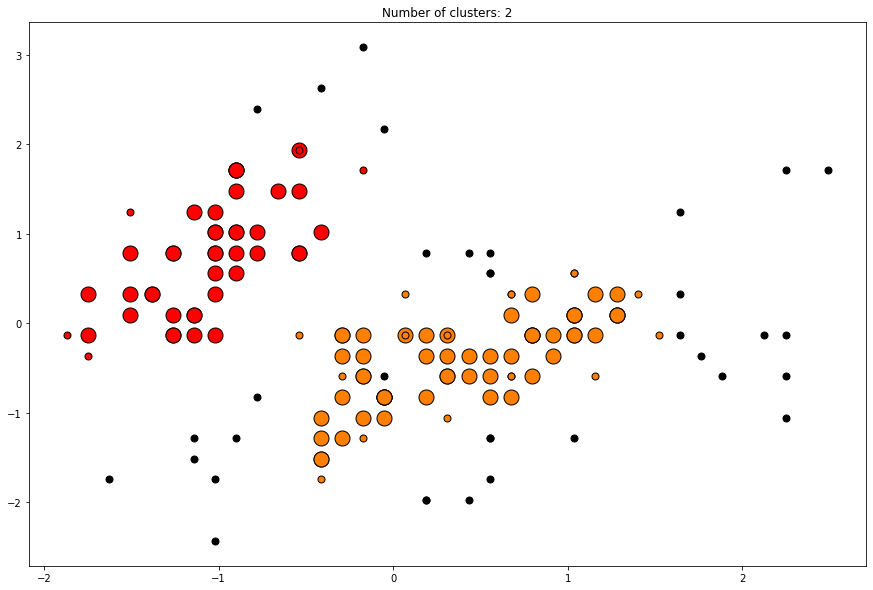

In [13]:
dbscan_plot(X,0.5,5)

### eps = 0.5 & min_samples = 10

In [14]:
dbscan(X,0.5,10,labels_true)

Homogeneity =  0.4563903557594016
Completeness =  0.47441738843318737
V_measure =  0.46522930655950706
Adjusted rand =  0.2791905028336968
Adjusted Mutual Information 0.44569731961211206


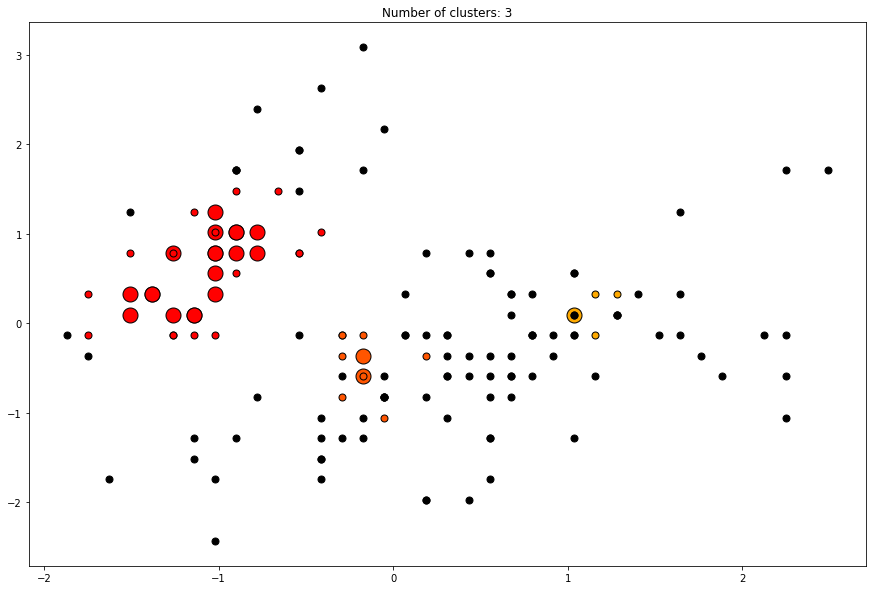

In [15]:
dbscan_plot(X,0.5,10)

### eps = 0.5 & min_samples = 15

In [16]:
dbscan(X,0.5,15,labels_true)

Homogeneity =  0.18065201923053967
Completeness =  0.4632222106066334
V_measure =  0.2599328372551412
Adjusted rand =  0.10448835295587426
Adjusted Mutual Information 0.1754843260430822


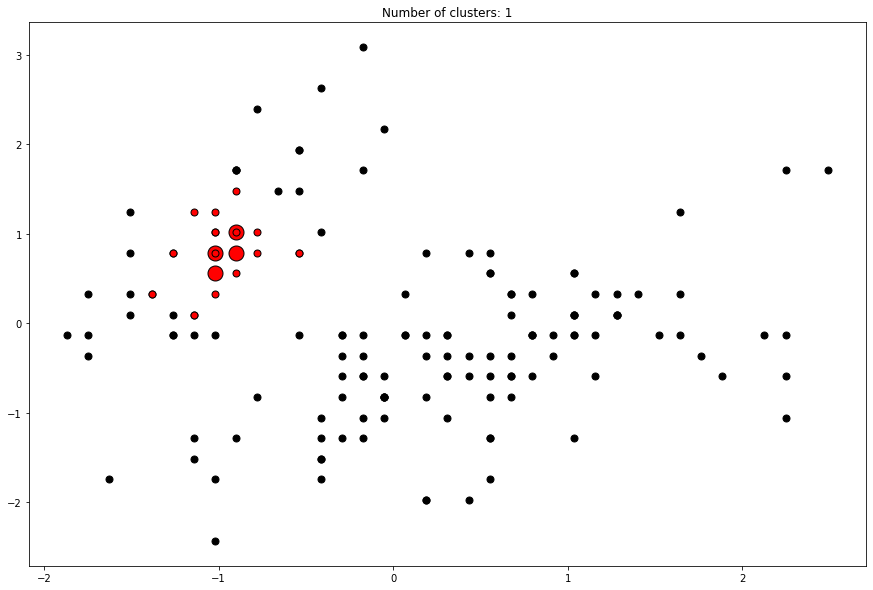

In [17]:
dbscan_plot(X,0.5,15)

### eps = 0.6 & min_samples = 5

In [18]:
dbscan(X,0.6,5,labels_true)

Homogeneity =  0.5180739608524721
Completeness =  0.5656029245001102
V_measure =  0.5407961567255838
Adjusted rand =  0.47062673356811163
Adjusted Mutual Information 0.5120119701209228


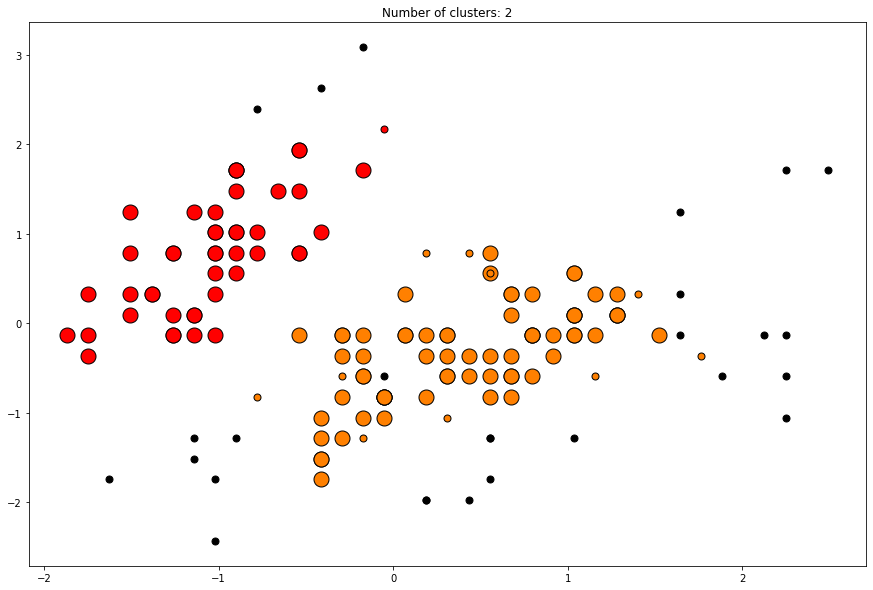

In [19]:
dbscan_plot(X,0.6,5)

### eps = 0.8 & min_samples = 5

In [20]:
dbscan(X,0.8,5,labels_true)

Homogeneity =  0.5786307346837466
Completeness =  0.854392870966849
V_measure =  0.6899788289414183
Adjusted rand =  0.5517553852833211
Adjusted Mutual Information 0.5727112749792933


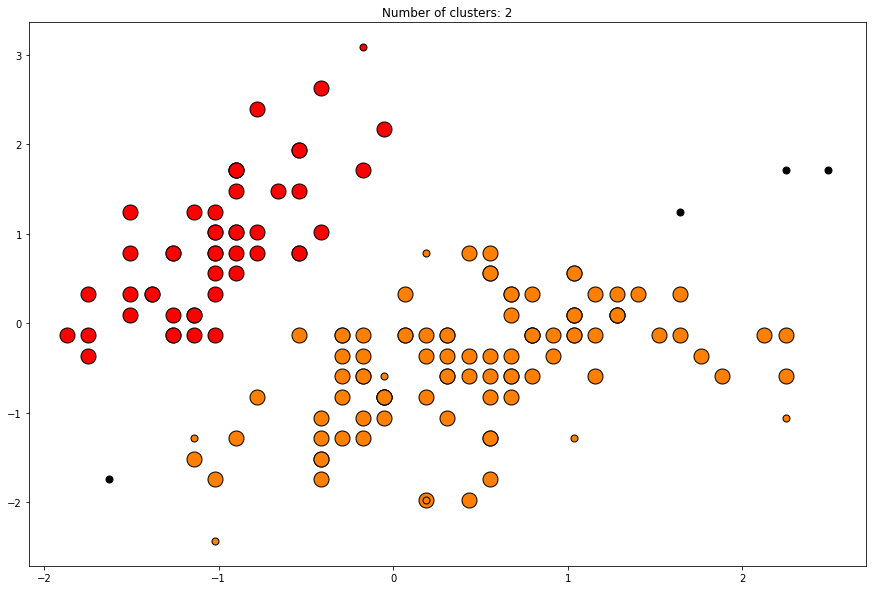

In [21]:
dbscan_plot(X,0.8,5)

### eps = 1 & min_samples = 5

In [22]:
dbscan(X,1,5,labels_true)

Homogeneity =  0.5763288083839111
Completeness =  0.8771705982981065
V_measure =  0.6956159505019279
Adjusted rand =  0.5535820784912957
Adjusted Mutual Information 0.5702996745838961


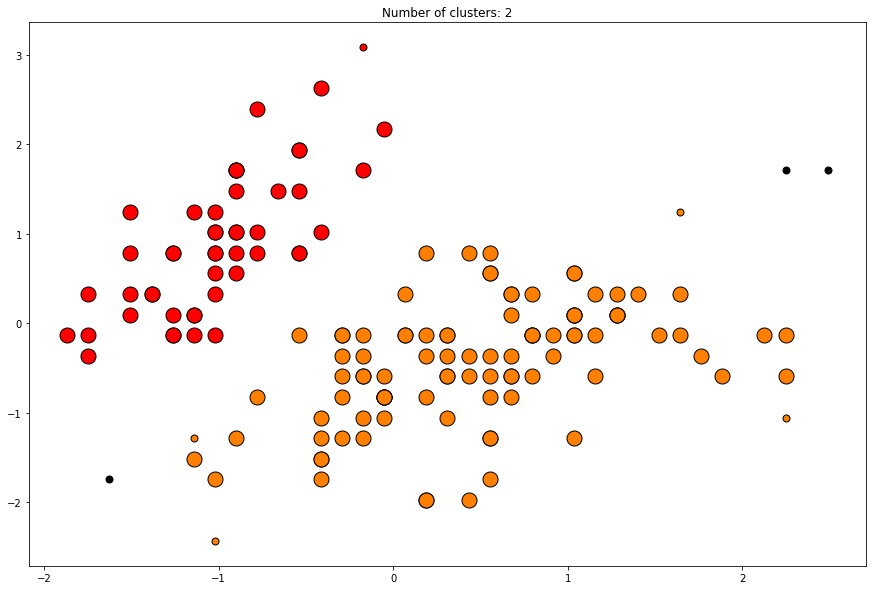

In [23]:
dbscan_plot(X,1,5)

It seems that DBscan is highly sensetive to the parameter changes

### K-Means

In [24]:
kM = KMeans(n_clusters=3)
pred = kM.fit_predict(X)

In [25]:
def acc_KM(labels_true, labels):
    # Homogeneity
    hmgnty = metrics.homogeneity_score(labels_true, labels)
    print('Homogeneity = ', hmgnty)
    
    # Completeness
    cmpltnss = metrics.completeness_score(labels_true, labels)
    print('Completeness = ', cmpltnss)
    
    # V-measure
    vmeasr = metrics.v_measure_score(labels_true, labels)
    print('V_measure = ', vmeasr)
    
    # Adjusted Rand Index
    adjrnd = metrics.adjusted_rand_score(labels_true, labels)
    print('Adjusted rand = ', adjrnd)
    
    # Adjusted Mutual Information
    mutinfo = metrics.adjusted_mutual_info_score(labels_true, labels)
    print('Adjusted Mutual Information',mutinfo)

### K-Means Clustring result

In [26]:
acc_KM(labels_true, pred)

Homogeneity =  0.6591265018049008
Completeness =  0.6598476779627759
V_measure =  0.659486892724918
Adjusted rand =  0.6201351808870379
Adjusted Mutual Information 0.6548603058807271


### Plot the clusters

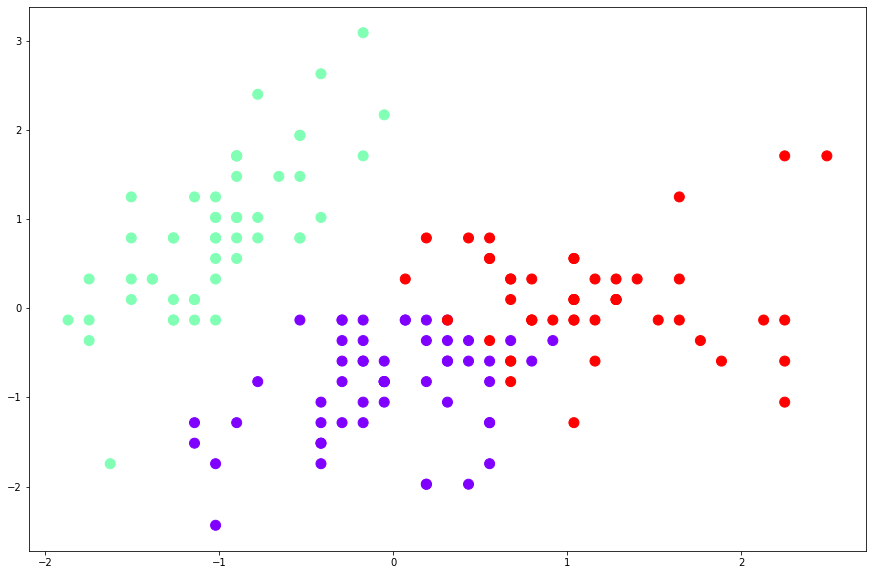

In [27]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(X[:,0],X[:,1],c=pred,cmap='rainbow',s = 100)

We do not need K-fold cross validation first, because here we are examining unsupervised learning and we assume that we do not know the true lables, second here we do not have clear definition of error to estimate the model generalization error rather than supervised learning. In this example (K-Means and DBscan) we just need to know the number of clusters from the ground truth to evaluate the clustring results. 

# Extra Points ( 5pts)
Implement DBScan by using the KD-tree (you can use for the  KD-tree the implementation in scikit or Numpy). Note that the KD-tree is used for  K-nearest neighbor. 